## Visualize just the fungal matches

In a given metagenome, there are usually far fewer fungal matches than bacteria. 
This notebook zooms in on just the fungal matches so they can be more clearly visualized with the bacterial components removed.

In [2]:
setwd("..")

In [71]:
# adjust plot size rendered inline
options(repr.plot.width = 6, repr.plot.height = 5, repr.plot.res = 300)

In [5]:
library(readr)
library(dplyr)
library(tidyr)
library(purrr)
library(tibble)
library(ggplot2)
library(ggthemes)
library(plotly)
library(ComplexUpset)

In [6]:
# read in custom functions into global environment
source("scripts/utils.R") # contains function fromList().

## Read in sourmash taxonomy results

In [15]:
# USER-DEFINED FILTERING THRESHOLD
# This repository sets sourmash gather's --threshold-bp parameter to 0, meaning we will return all matches even if there is only 1 k-mer overlap.
# Because we only want to work with results we are confident, we'll set a filtering threshold.
# I think 20,000bp (equivalent to 20 hashes) is a stringent threshold.
# This number is probably least appropriate for viruses and community members that are present at very low abundance (e.g. potential archaea).
intersect_bp_threshold <- 20000

In [16]:
# read in the sourmash taxonomy results from all samples into a single data frame
sourmash_taxonomy_results <- Sys.glob("outputs/sourmash_taxonomy/*genbank-2022.03-k31.with-lineages.csv") %>%
  map_dfr(read_csv, col_types = "ddddddddcccddddcccdc") %>% # read in all of the taxonomy results
  mutate(name = gsub(" .*", "", name)) %>%  # simplify the genome name to only include the accession
  separate(lineage, into = c("domain", "phylum", "class", "order", "family", "genus", "species", "strain"), sep = ";", remove = F) %>% # separate out taxonomic levels
  mutate(lowest_taxonomic_assignment = ifelse(!is.na(strain), strain, species), # make a label for plots
         lineage_species = paste(domain, phylum, class, order, family, genus, species, sep = ";"),  # make a lineage that doesn't include strain
         database = basename(filename)) %>% # simplify database name
  filter(database == "genbank-2022.03-fungi-k31.zip") %>%
  filter(intersect_bp >= intersect_bp_threshold)

Warning message:
“Expected 8 pieces. Missing pieces filled with `NA` in 4999 rows [1, 2, 3, 4, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, ...].”


In [17]:
length(unique(sourmash_taxonomy_results$name))

[1] 11

In [18]:
length(unique(sourmash_taxonomy_results$species))

[1] 4

In [19]:
length(unique(sourmash_taxonomy_results$genus))

[1] 3

## what fungal genomes are present, and how much of that genome compared to the genome size do we actually observe in the metagenome

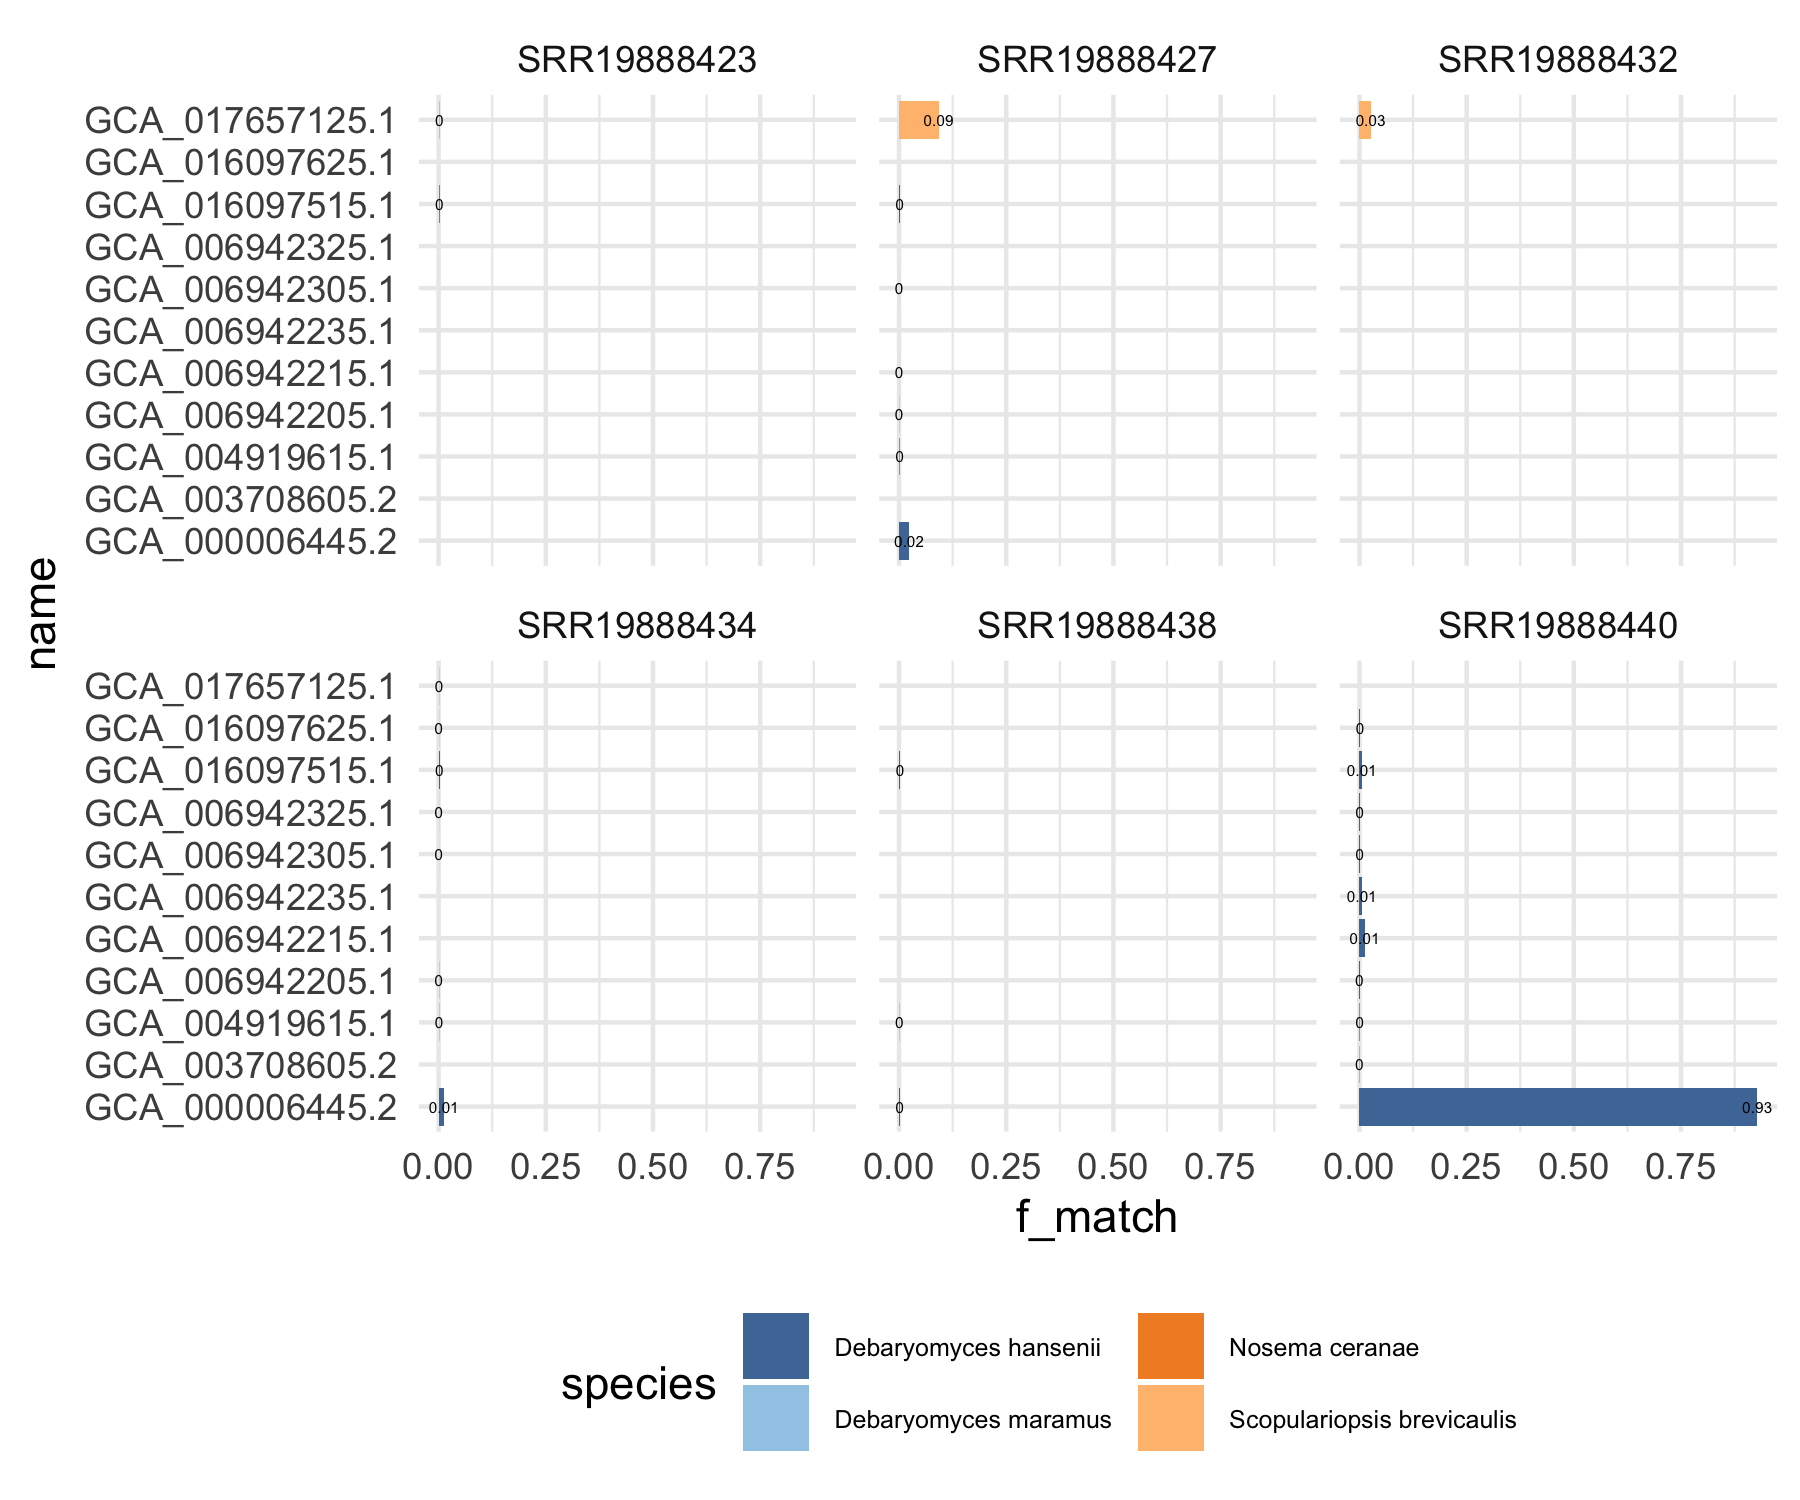

In [72]:
ggplot(sourmash_taxonomy_results, aes(x = name, y = f_match, fill = species)) +
  geom_col() +
  coord_flip() +
  theme_minimal() +
  geom_text(aes(label = round(f_match, digits = 2)), size = 1.3) +
  scale_fill_tableau(palette = "Tableau 20") +
  theme(legend.position = "bottom", legend.text = element_text(size = 6)) +
  guides(fill = guide_legend(ncol=3)) +
  facet_wrap(~query_name)

## upset plot

In [26]:
# re-read in taxonomy results in list format instead of parsing from the above data
files <- Sys.glob("outputs/sourmash_taxonomy/*k31*csv") # list files in the taxonomy folder that contain k31 and end with .csv
sourmash_taxonomy_upset_list <- list()
for(i in 1:length(files)){
    taxonomy <- read_csv(files[i], show_col_types = F)         # read in the sourmash taxonomy results
    taxonomy <- taxonomy %>%
      mutate(database = basename(filename)) %>%                # simplify database name
      filter(database == "genbank-2022.03-fungi-k31.zip") %>%  # filter to fungi...
      filter(intersect_bp >= intersect_bp_threshold)           # ...that we see at least 20kbp from
    sample_name <- unique(taxonomy$query_name)                 # record the signature name which is currently stored as the column name
    sourmash_taxonomy_upset_list[[i]] <- taxonomy$lineage      # record the lineage names in a list
    names(sourmash_taxonomy_upset_list)[i] <- sample_name      # set the name of the list index to the signature name
}

In [27]:
# re-format the list into format needed to make upset plot
upset_df <- fromList(sourmash_taxonomy_upset_list)

In [28]:
# pick best level of taxonomy to color at.
# If we use the Tableau 20 palette in ggthemes, we can viz up to 20 colors


In [29]:
# re-derive appropriate color labels using lineages

# first, make a data frame that has lineage:color mapping, where color will be some level of taxonomy
lineage_to_db <- sourmash_taxonomy_results %>%
  select(species, lineage) %>%
  distinct()

upset_df <- upset_df %>%
  rownames_to_column("lineage") %>%
  left_join(lineage_to_db, by = "lineage")

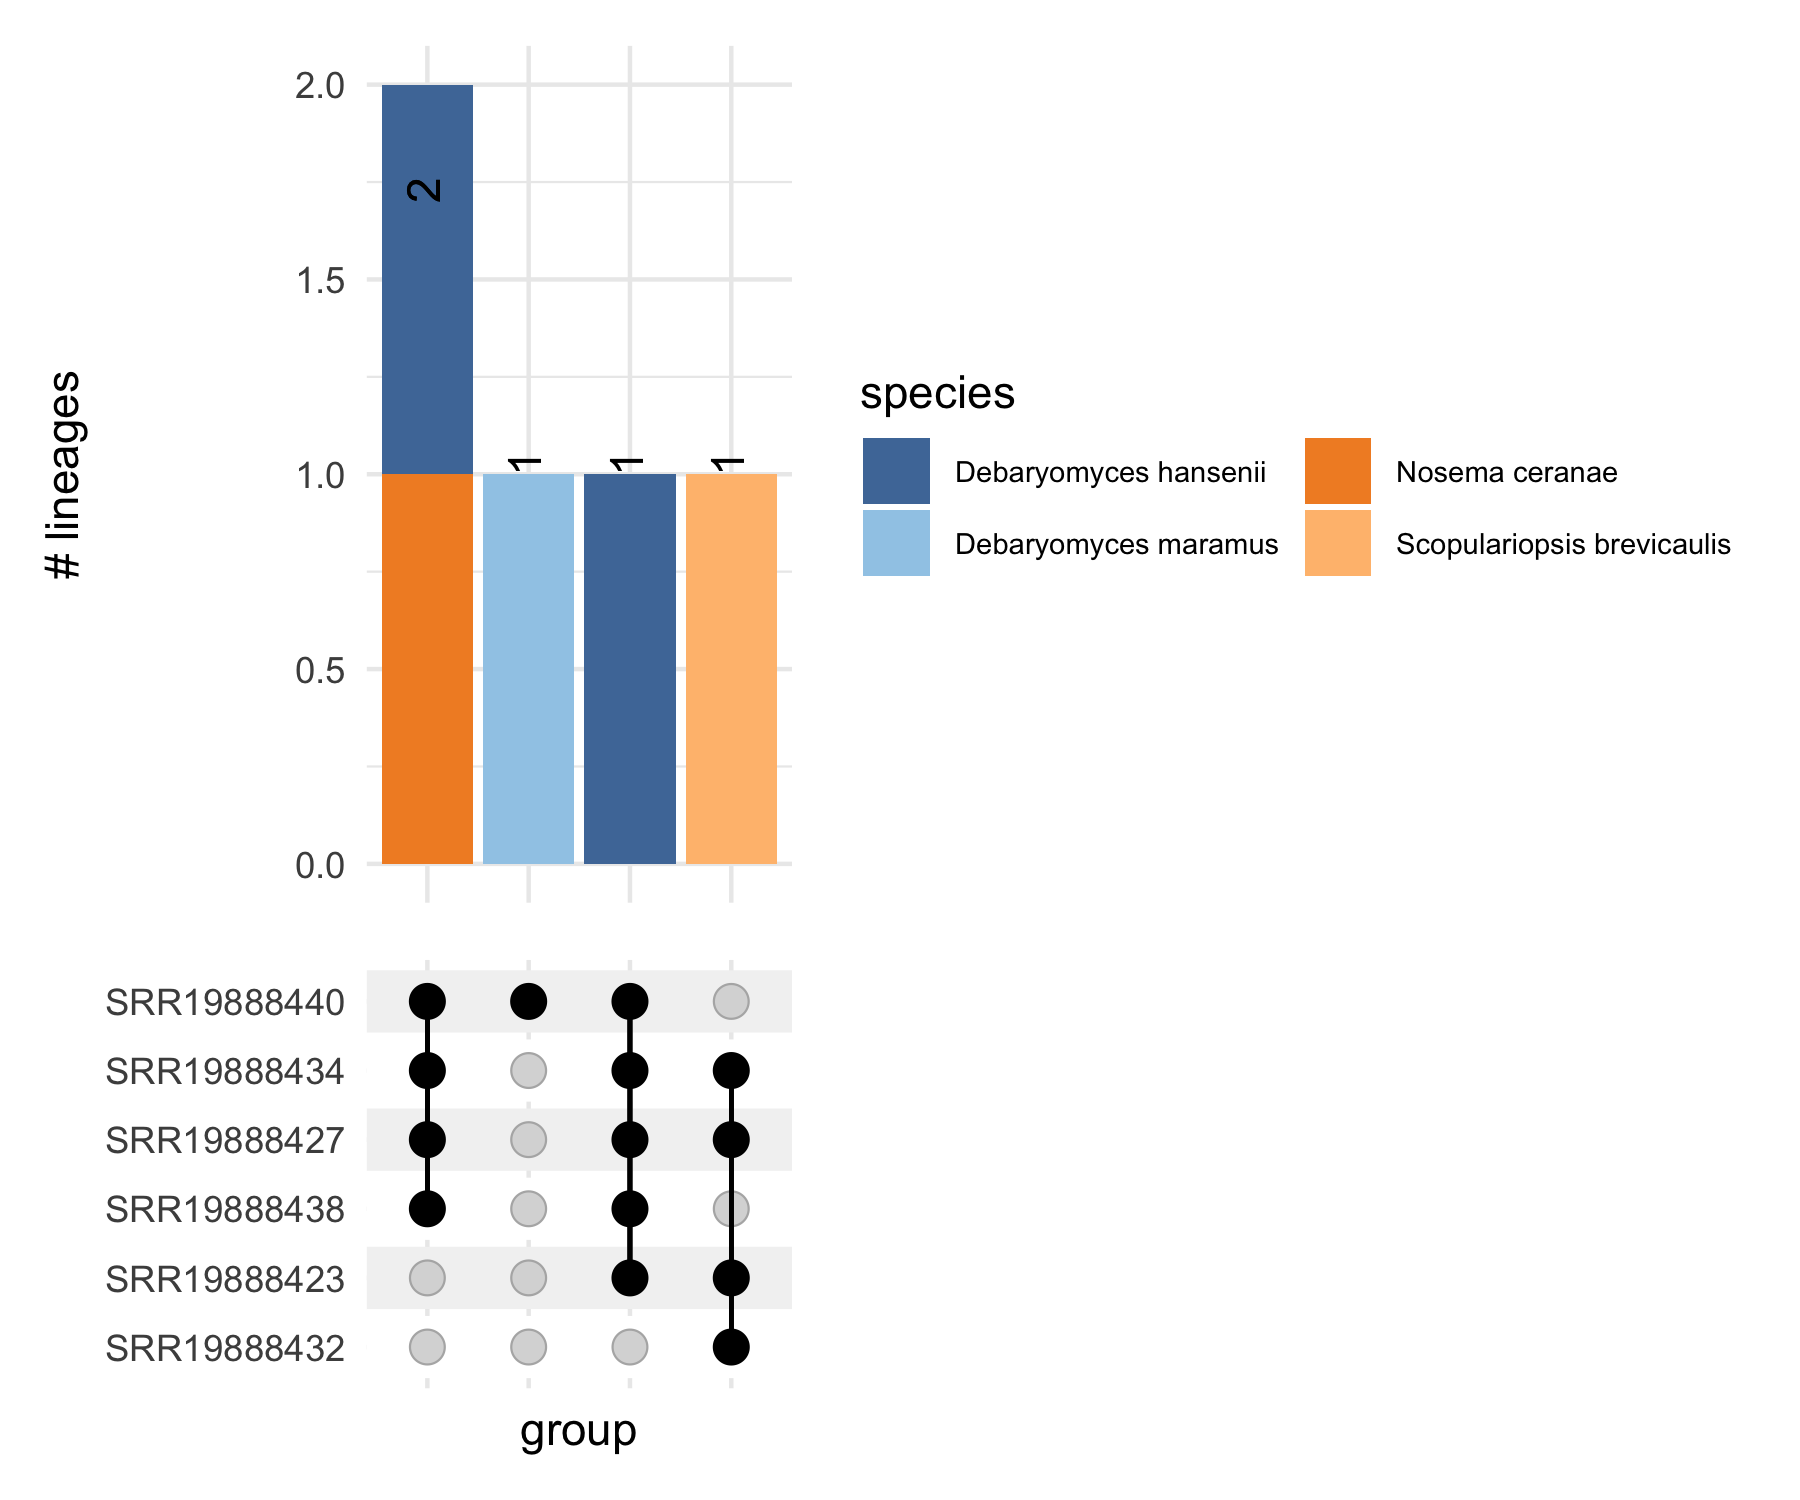

In [73]:
# plot the upset plot
upset(upset_df, intersect = names(sourmash_taxonomy_upset_list), set_sizes = F, 
      base_annotations=list(
          '# lineages'=intersection_size(text=list(vjust=0.4, hjust=.05, angle=90), 
                                                          text_colors=c(on_background='black', on_bar='black'),
                                                          mapping=aes(fill=species)) +
          scale_fill_tableau(palette = "Tableau 20") +
          theme(legend.text = element_text(size = 7)) +
          guides(fill=guide_legend(ncol=2)))
     )